In [1]:
!pip install gdown
!pip install pandas
!pip install transformers
!pip install datasets
!pip install torch
!pip install matplotlib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.7/12.7 MB 36.7 MB/s eta 0:00:0000:01


In [2]:
%run downoald_and_cleaning_data.ipynb

Downloading...
From (original): https://drive.google.com/uc?id=1UR_MC8Q5K4JSRnSUX5MQ-sIGPjLLnm9f
From (redirected): https://drive.google.com/uc?id=1UR_MC8Q5K4JSRnSUX5MQ-sIGPjLLnm9f&confirm=t&uuid=9762fac8-9ba6-443a-83e8-48eb6c67a399
To: /home/onyxia/work/PSSD/Data/data.csv
100%|██████████| 363M/363M [00:05<00:00, 64.8MB/s] 


In [4]:
df = pd.read_csv("data_clean.csv")


In [3]:
df.dropna(subset=['texte'], inplace=True)

In [4]:
df['texte'] = df['texte'].str.lower()

In [5]:
import re
from tqdm import tqdm

tqdm.pandas()
df['texte_clean'] = df['texte'].str.lower().progress_apply(lambda x: re.sub(r'[^\w\s]', '', x))
df['titre_clean'] = df['titre'].str.lower().progress_apply(lambda x: re.sub(r'[^\w\s]', '', x))


100%|██████████| 81557/81557 [00:00<00:00, 281583.88it/s]


In [89]:
from transformers import pipeline
import datasets

classifier = pipeline(
    "zero-shot-classification",
    model="mtheo/camembert-base-xnli",
    device=0,
    hypothesis_template="Cet article parle de {}."
)
candidate_labels = [
    "faits divers",
    "économie",
    "politique",
    "cinéma",
    "mode",
    "musique",
    "sport",
    "tribune"
]
def batch_classify(df, text_column='texte', batch_size=96):
    texts = df[text_column].fillna(" ").tolist()
    texts = [t if isinstance(t, str) and t.strip() != "" else " " for t in texts]
    dataset = Dataset.from_dict({"text": texts})
    
   
    def batching(batch):
        results = classifier(
            batch["text"],
            candidate_labels=candidate_labels,
            batch_size=batch_size
        )
        batch_themes = [res["labels"][0] for res in results]
        return {"theme": batch_themes}
    
  
    dataset = dataset.map(
        batching,
        batched=True,
        batch_size=batch_size
    )
    
    return dataset.to_pandas()

Device set to use cuda:0


In [19]:
def filter_empty_lines(df, text_column='titre_clean'):
    filtered_df = df[~(df[text_column].isna() | (df[text_column].str.strip() == ''))].copy()
    filtered_df = filtered_df.reset_index()  
    print(f"Lignes initiales : {len(df)}")
    print(f"Lignes après filtrage : {len(filtered_df)}")
    return filtered_df

df_filtered = filter_empty_lines(df, text_column='titre_clean')


Lignes initiales : 81557
Lignes après filtrage : 81554


In [92]:
results = batch_classify(df_filtered, text_column='titre_clean', batch_size=164)

Map: 100%|██████████| 81554/81554 [38:21<00:00, 35.44 examples/s]  


In [93]:
df_filtered['theme'] = results['theme'].values

In [94]:
df_filtered.tail(10)

,index,identifiant,journal,journal_clean,titre,complement,annee,mois,jour,heure,...,date,epoch,auteur,texte,keywords,langue,url,texte_clean,titre_clean,theme
81544,82202,2bbb2550ad1c7c7a8df320551988346bf6166f93ac314b...,Yahoo! Finance France (site web réf.) - Yahoo!...,Yahoo! Finance France,Justice : Enquête après une plainte de Sara Fo...,5 décembre 2024 252 mots | | |,2024,12,5,0,...,2024 12 05T00:00:00,1733353200,Unknown,#metoo - dans un entretien vidéo à mediapart...,"nicolas, forestier, duvauchelle, sara",fr,NaN,metoo dans un entretien vidéo à mediapart ...,justice enquête après une plainte de sara for...,faits divers
81545,82203,fae9668f85357869b3f524a6047a5d3949c3fd3165d77c...,Nice-Matin (site web réf.) - NiceMatin,Nice-Matin,Affaire Adèle Haenel: le réalisateur Christoph...,5 décembre 2024 756 mots | | |,2024,12,5,0,...,2024 12 05T00:00:00,1733353200,Unknown,france justice affaire adèle haenel: le réalis...,NaN,fr,NaN,france justice affaire adèle haenel le réalisa...,affaire adèle haenel le réalisateur christophe...,cinéma
81546,82204,7bfdf54884e49795fadc90d4ec3f47a50b999d6c0c6084...,Sud Ouest - Sud-Gironde,Sud Ouest,"Soupçonné d’un viol, il est interpellé dix moi...","Gironde, jeudi 5 décembre 2024 356 mot...",2024,12,5,0,...,2024 12 05T00:00:00,1733353200,jean-michel desplos; [email protected],bordeaux ils n’ont jamais lâché l’affaire. l...,"d’un, mois, l’affaire, bordeaux, viol, interpe...",fr,NaN,bordeaux ils nont jamais lâché laffaire les ...,soupçonné dun viol il est interpellé dix mois ...,faits divers
81547,82205,ce0964ef7217cad5386f93bbae1cb061fd73c24e015a0b...,Sud Ouest (site web),Sud Ouest,"Soupçonné d'un viol en pleine rue à Bordeaux, ...","Accueil\n Gironde, je...",2024,12,5,0,...,2024 12 05T00:00:00,1733353200,par jean-michel desplos,"en février, une femme trentenaire avait été ag...","rue, mois, région_parisienne, interpellé, pari...",fr,https://www.sudouest.fr/gironde/soupconne-d-un...,en février une femme trentenaire avait été agr...,soupçonné dun viol en pleine rue à bordeaux il...,faits divers
81548,82206,bf60819980a55df3fc73b1c811dbe4c6b29285a13d5af4...,20 Minutes (site web) - 20Minutes,20 Minutes,Enquête après une plainte de Sara Forestier co...,jeudi 5 décembre 2024 - 05:17:13 -0000 447 mot...,2024,12,5,5,...,2024 12 05T05:17:13,1733372233,Unknown,dans un entretien vidéo à mediapart diffusé ma...,"giflée, duvauchelle, vidéo, mediapart, entreti...",fr,https://www.20minutes.fr/arts-stars/culture/41...,dans un entretien vidéo à mediapart diffusé ma...,enquête après une plainte de sara forestier co...,faits divers
81549,82207,0f7483a65bfadbdbf7d94d513bbeaf5d9b6b5a77f9becb...,AFP - Infos Françaises,AFP,#Metoo français: l'affaire Adèle Haenel devant...,jeudi 5 décembre 2024 - 08:30:20 UTC 742 mots ...,2024,12,5,8,...,2024 12 05T08:30:20,1733383820,Unknown,"paris, 5 déc 2024 (afp) - en parlant, elle av...","adèle, haenel, procès, justice, cinéma, lundi,...",fr,NaN,paris 5 déc 2024 afp en parlant elle avait o...,metoo français laffaire adèle haenel devant la...,faits divers
81550,82208,43f80da551c32fb8107121f21b3a2fa295830bb5fc09c8...,Midi Libre (site web),Midi Libre,"""Je sortais d'une chimiothérapie"" : une femme ...",jeudi 5 décembre 2024 - 11:25:34 270 mots | | |,2024,12,5,11,...,2024 12 05T11:25:34,1733394334,théoline cotentin,"ce mardi dans la matinée, une femme handicapée...","handicapée, chimiothérapie, visage, voile, res...",fr,https://www.midilibre.fr/2024/12/05/je-sortais...,ce mardi dans la matinée une femme handicapée ...,je sortais dune chimiothérapie une femme hand...,faits divers
81551,82209,541016263935838efcb3c83f43780e64f330fb997f3564...,L'Indépendant (site web),L'Indépendant,"""C'est ce que je ressens quand tu me trompes"" ...",jeudi 5 décembre 2024 - 11:26:44 436 mots | | |,2024,12,5,11,...,2024 12 05T11:26:44,1733394404,hugo martin,laissant dedans pendant des heures jusqu'à sa ...,"étouffé, valise, ressens, trompes, verres",fr,https://www.lindependant.fr/2024/12/05/cest-ce...,laissan

In [95]:
df_faits = df_filtered[df_filtered['theme']=='faits divers']

In [96]:
df_faits.shape

(39263, 22)

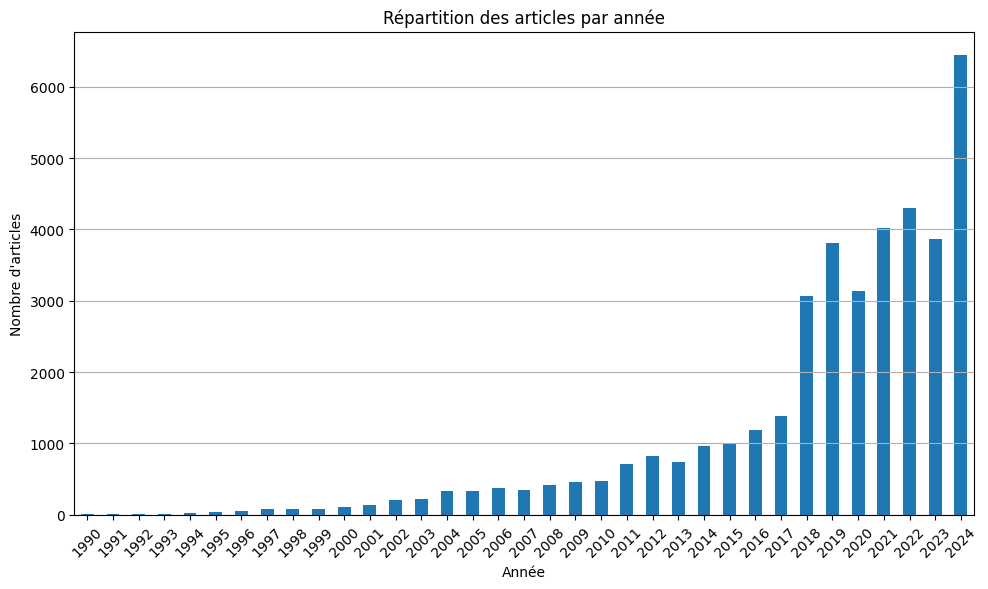

In [99]:
import matplotlib.pyplot as plt
articles_par_annee = df_faits['annee'].value_counts().sort_index()
plt.figure(figsize=(10, 6))
articles_par_annee.plot(kind='bar')
plt.title("Répartition des articles par année")
plt.xlabel("Année")
plt.ylabel("Nombre d'articles")
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.tight_layout()
plt.show()

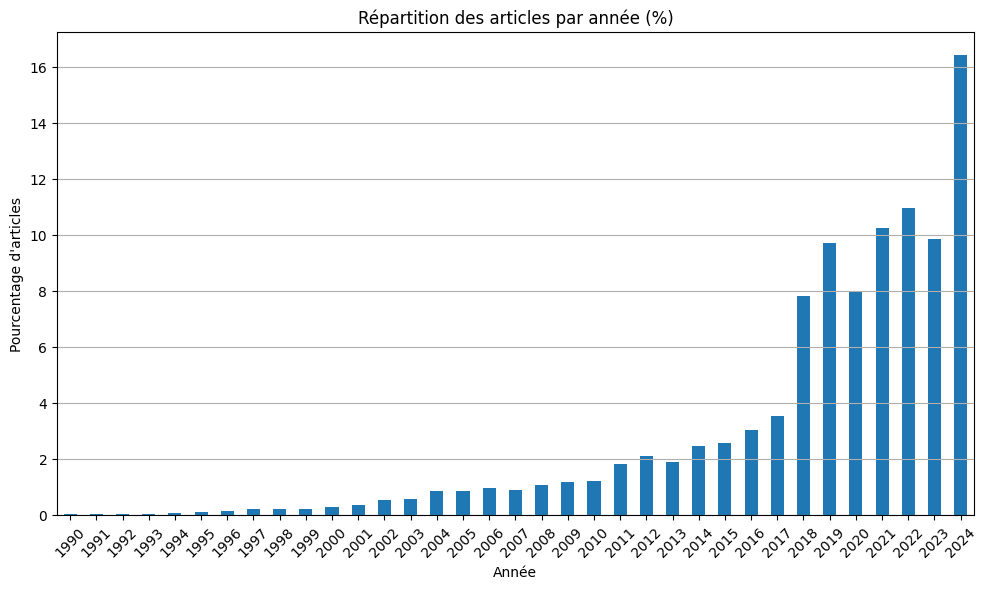

In [100]:
articles_par_annee = df_faits['annee'].value_counts(normalize=True).sort_index() * 100
plt.figure(figsize=(10, 6))
articles_par_annee.plot(kind='bar')
plt.title("Répartition des articles par année (%)")
plt.xlabel("Année")
plt.ylabel("Pourcentage d'articles")
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.tight_layout()
plt.show()

In [101]:
df_faits.to_csv('data_faits_divers.csv')